<!-- # Data for the Final Project
Over the semester, I've gone through multiple ideas for what to do for the final project.

* I started wanting to look at global warming/emissions/fossile fuel data
* I then wanted to look at death rate data, and I found some decent data sources for it
* Now, we have a family reunion coming up, and I gave everyone a survey to fill out, so I could gather data to get some fun stats. I want to make a funny presentation and/or a Family Fued-style presentation to give at the family reunion. I also made a website for it, so I want to put it on there. The data for it is in the link below, I made a Google Form to collect it all. Since it's *kind of* personal data, I don't know if I should share it. There's nothing too personal, but I didn't ask permission.
* My grandma also showed me a sprawling 30+ page Microsoft word document of every significant event since she got married, so I wrote some code to parse it, clean it, then make an interactive timeline of it, and also published it on the family reunion website. Only problem with that is that I already did that, and I did it in Python. But it could use some more work, so I might come back to it. I definitely shouldn't share that data without permission.
* I *also* really loved the interactive treemap of the size of files on a computer that was shown in class briefly, so I wrote a script to see that. I started on that, but I started it in Python, because I couldn't find an interactive treemap library for ggplot, and I really wanted it to be interactive. Plotly has one, but I couldn't find an R version of it. At first I used the `du` command to generate a .tsv file of all the files, but then decided I wanted more info, like the file type and when it was last accessed, and things like that, so I wrote a python script (using `os.walk()`) to get more detailed data. I really like the idea of generating a dataset, instead of collecting one.
* My dad also had me make some graphs to help him make a business decision, specifically a graph of the population growth in a few specific counties in Idaho, with the optometrists in each county plotted. I made a graph for that, also in Python, because I did it before the week on leaflet and graphs, and because I wanted to publish it using Streamlit. I could redo it in R. The data for that I got by downloading and parsing census data by hand. I found an R package that can automatically download and clean census data for you, but it only works up to 2019, because apparently in 2020 the goverment changed how they formatted the census data, and my dad wanted the newest population data possible. I ended up using both census data and ACS data combined. My dad said he'd get me the dataset for the optometrists, but he hasn't gotten it to me yet.

This file is making some graphs and stats (sometimes *intentionally* bad, for comedic effect) for the family reunion -->

In [534]:
#| echo: false
library(tidyverse)
library(gsheet)
library(lubridate)
library(glue)
library(ggrepel)
options(
    repr.matrix.max.rows=20,
    repr.matrix.max.cols=200,
    repr.plot.width=10,
    repr.plot.height=8
)

In [491]:
#| echo: false
library(showtext)
library(xkcd)
font_add(family='xkcd', regular='~/.fonts/xkcd.ttf')
showtext_auto()

In [492]:
# data = gsheet2tbl('https://docs.google.com/spreadsheets/d/1oUMIpE_Elh_CYD7DFbT1vbYxFZNYUDK2QxFqFDk4xII/edit#gid=2008169700') # Original Data
data = gsheet2tbl('https://docs.google.com/spreadsheets/d/1oUMIpE_Elh_CYD7DFbT1vbYxFZNYUDK2QxFqFDk4xII/edit?gid=0#gid=0') # Manually cleaned data (it was easier to edit it in the spreadsheet)

In [493]:
questions = colnames(data)
colnames(data) = c('timestamp', 'name', 'birthday', 'parents', 'names.indexed', 'ordinances.self', 'ordinances.dead', 'fav.recipe', 'gen', 'tech.savviness', 'injuries', 'num.trips', 'trips', 'num.pets', 'pets', 'fav.part', 'suggested.activity', 'suggested.reunion.location', 'jobs', 'most.told.story', 'oldest', 'rating', 'fav.game', 'secret', 'best.advice', 'worst.advice', 'coming')
data$age = floor((today() - mdy(data$birthday)) / 365) |> as.integer()
data$first.name.raw = str_split(data$name, pattern=' ') |> map(~ .x[[1]]) |> as.character()

In [494]:
# Function to make names unique
make_names_unique <- function(names) {
    # Create a data frame to store the unique names and their counts
    name_counts <- data.frame(names, count = ave(names, names, FUN = seq_along))

    # Append the count to the names if count > 1
    name_counts <- name_counts %>%
        mutate(unique_names = ifelse(count == 1, names, str_c(names, " #", count)))

    return(name_counts$unique_names)
}

data$first.name = make_names_unique(data$first.name.raw)

In [495]:
# Some people (the Hardy's) put in ridiculous data
# This is fun for some graphs, but not others
serious_data = data |>
    filter(tech.savviness != 10 | first.name == 'Copeland') |>
    filter(!(first.name.raw %in% c('Bethany', 'Trump', 'Biden', 'Wuss')))

In [496]:
theme_set(theme_xkcd())
theme_update(
    plot.background = element_rect(fill='#222222'),
    panel.grid.major = element_line(color='#807f7f'),
    panel.background = element_rect(fill='#3f3f3f'),
    axis.text = element_text(color='gray90'),
    plot.title = element_text(color='gray90', size=25),
    plot.subtitle = element_text(color='gray90', size=20),
    # plot.subtitle = text,
    # legend.text = text,
    # axis.text.x = text,
    # axis.text.y = text,
    text=element_text(color='gray90', size=20),
)
color = '#226796'

In [497]:
# I got sick of repeatedly doing this by hand
geom_arrow = function(x, y, dx, dy, text='', head='closed', text_dx=0, text_dy=0, arrow_head_len_in=.15){
    return(list(
        annotate('segment', xend=x, yend=y, x=x+dx, y=y+dy,
            arrow=arrow(type = head, length=unit(arrow_head_len_in, 'inches')),
            color=theme_get()$text$colour,
        ),
        annotate('text', x=x+dx+text_dx, y=y+dy+text_dy,
            label=text,
            family=theme_get()$text$family,
            size=theme_get()$text$size / 3,
            color =theme_get()$text$colour,
        )
    ))
}

Warning message:
“Removed 7 rows containing non-finite outside the scale range (`stat_bin()`).”


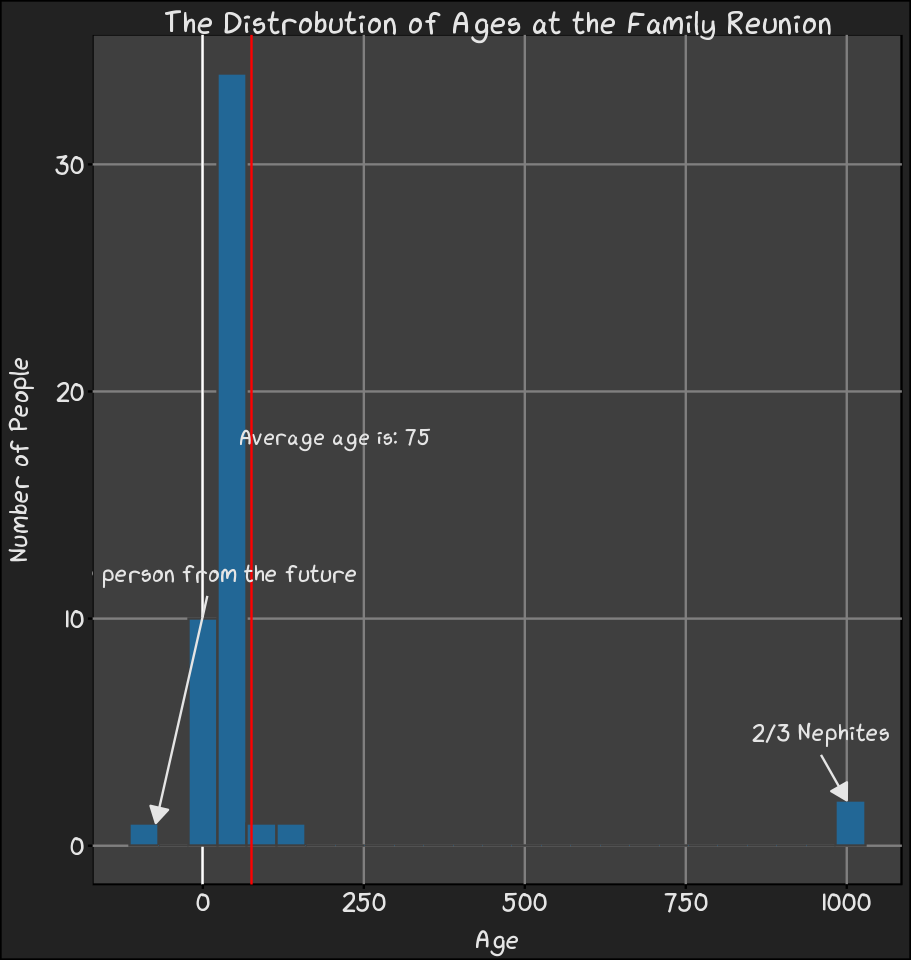

In [533]:
mean.age = mean((data %>% filter(., !is.na(age)))$age)
ggplot(data, aes(x=age)) +
    geom_vline(xintercept = 0, color='white') +
    geom_histogram(bins=25, fill=color, color=theme_get()$panel.background$fill) +
    # scale_x_binned(transform = 'sqrt')
    geom_arrow(x=1000, y=2, dx=-40, dy=2, text='2/3 Nephites', text_dy=1) +
    geom_vline(xintercept = mean.age, color='red') +
    annotate('text', x=mean.age + 130, y=18, label=paste0('Average age is: ', round(mean.age, 1)), color=theme_get()$text$colour, size=6, family=theme_get()$text$family,) +
    geom_arrow(x=-73, y=1, dx=80, dy=10, text='One person from the future', text_dy=1) +
    labs(
        title='The Distrobution of Ages at the Family Reunion',
        y='Number of People',
        x='Age'
    )


In [499]:
data |> arrange(desc(age)) |> head(8) |> select(name, age) |> clipr::write_clip(allow_non_interactive = T)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


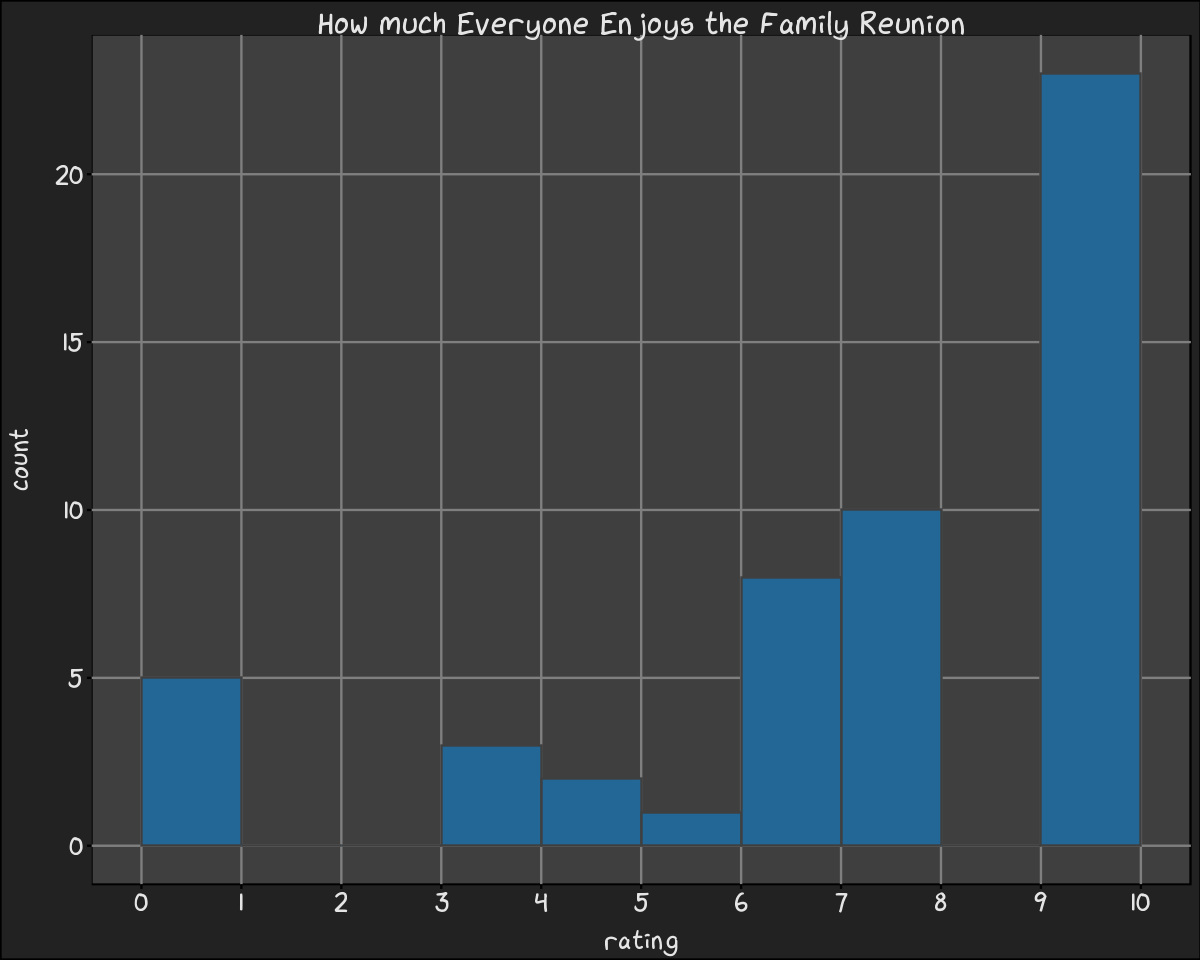

In [500]:
data |>
    filter(!is.na(rating)) |>
ggplot(aes(x=rating)) +
    geom_histogram(bins=11, color=theme_get()$panel.background$fill, fill=color) +
    scale_x_binned(breaks = 0:10) +
    labs(title = "How much Everyone Enjoys the Family Reunion")

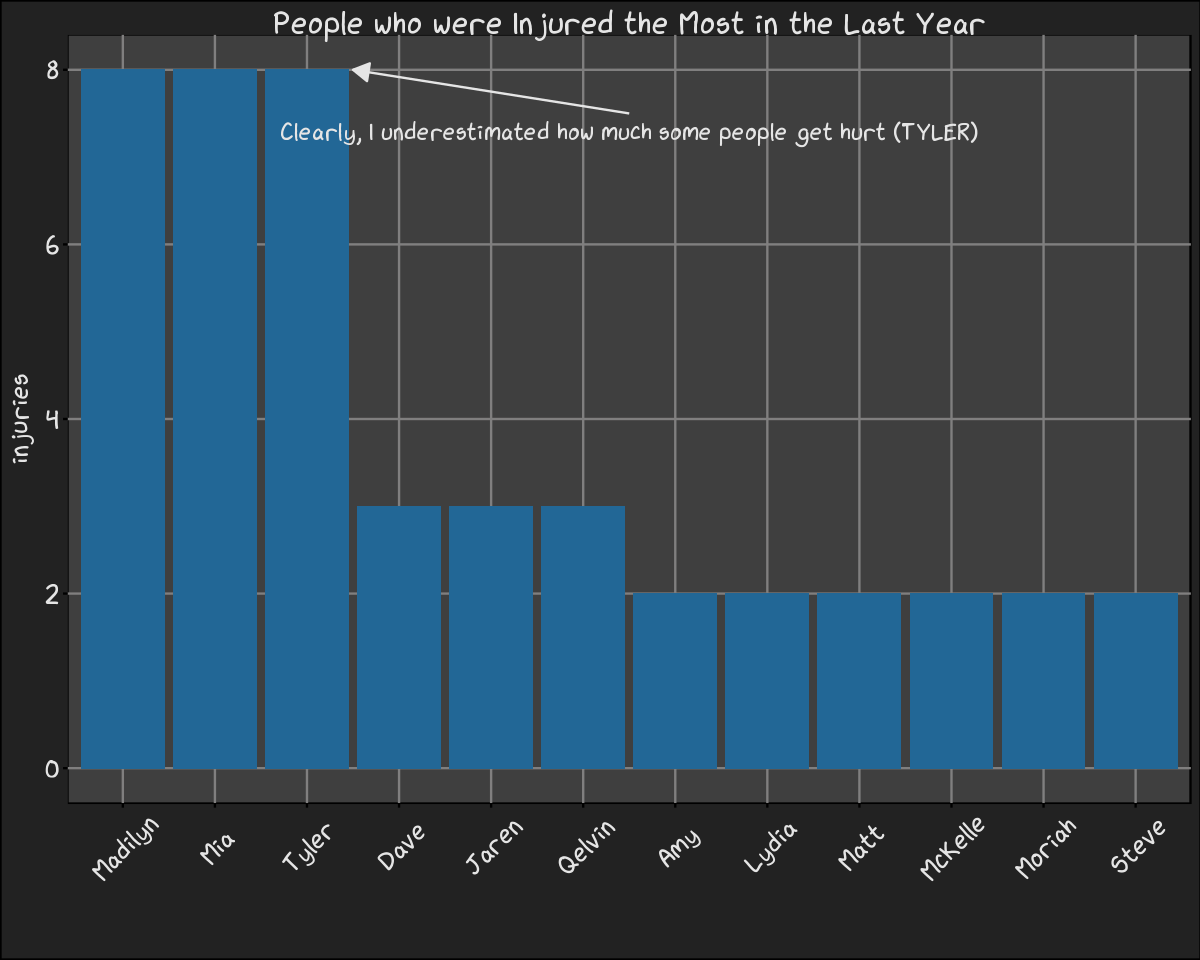

In [501]:
serious_data %>%
    filter(injuries > 1) |>
ggplot(aes(x=reorder(first.name, desc(injuries)), y=injuries)) +
    geom_col(fill=color) +
    geom_arrow(x=3.5, y=8, dx=3, dy=-.5, text='Clearly, I underestimated how much some people get hurt (TYLER)', text_dy=-.2) +
    theme(axis.text.x = element_text(angle=45,vjust = .7)) +
    labs(title='People who were Injured the Most in the Last Year', x='')

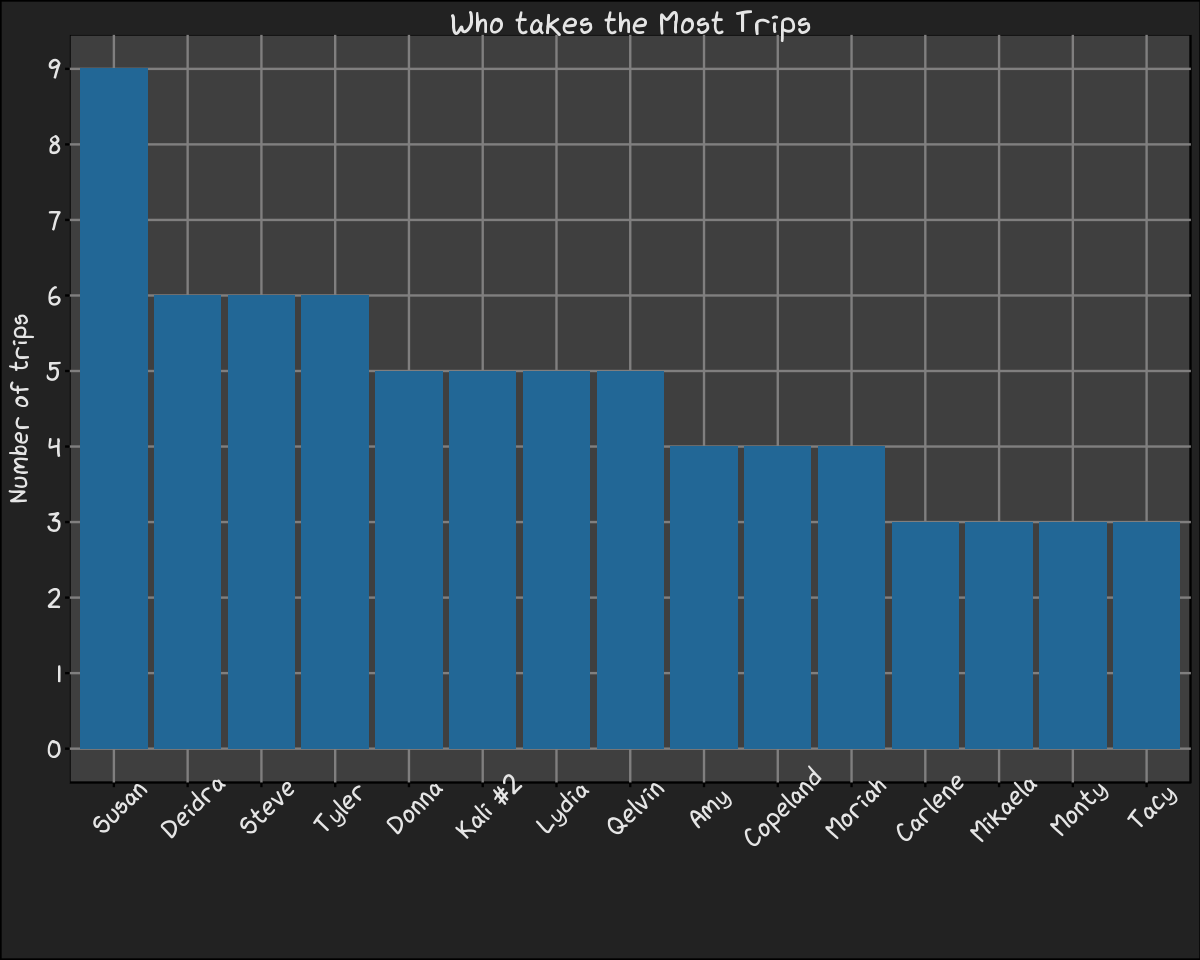

In [502]:
ggplot(serious_data |> filter(num.trips > 2), aes(x=reorder(first.name, desc(num.trips)), y=num.trips)) +
    geom_col(fill=color) +
    theme(axis.text.x = element_text(angle=45, vjust = .9, hjust = .5)) +
    scale_y_continuous(breaks=seq(0, 9, 1)) +
    labs(title = 'Who takes the Most Trips', x='', y='Number of trips')

In [ ]:
# eval: false
# echo: false
# I cannot for the life of me figure out why it's doing this. It just started doing it randomly. I'm starting
# to seriously suspect a bug in ggplot2.
honorable_mentions = c('Rice and butter', 'Pinto beans, Kale, and herbs on sourdough bread toasted with cheese on top.', 'Mash sauce', 'I love food', 'Horse apple', 'Danaes famous Grilled salmon', 'Chaos', 'Chinese takeout', 'Anything grandma makes', 'Black bean, rice, bell pepper, and mango with a lime dressing')
# honorable_mentions = c()
data %>%
    group_by(fav.recipe) %>%
    mutate(order = n()) |>
    filter(!is.na(fav.recipe)) |>
    filter(order > 1 | fav.recipe %in% honorable_mentions) |>
ggplot(aes(y=reorder(fav.recipe, order))) +
    geom_bar(orientation = 'y', stat='count', fill=color) +
    scale_x_continuous(breaks=0:6) +
    annotate('text', x=3, y=10.7, label='Honorable Mentions') +
    geom_hline(yintercept = 10.5, color='#cc312c') +
    labs(title = 'Everyone\'s Favorite Family Recipies', y='', x='Number of people who say it\'s their favorite')

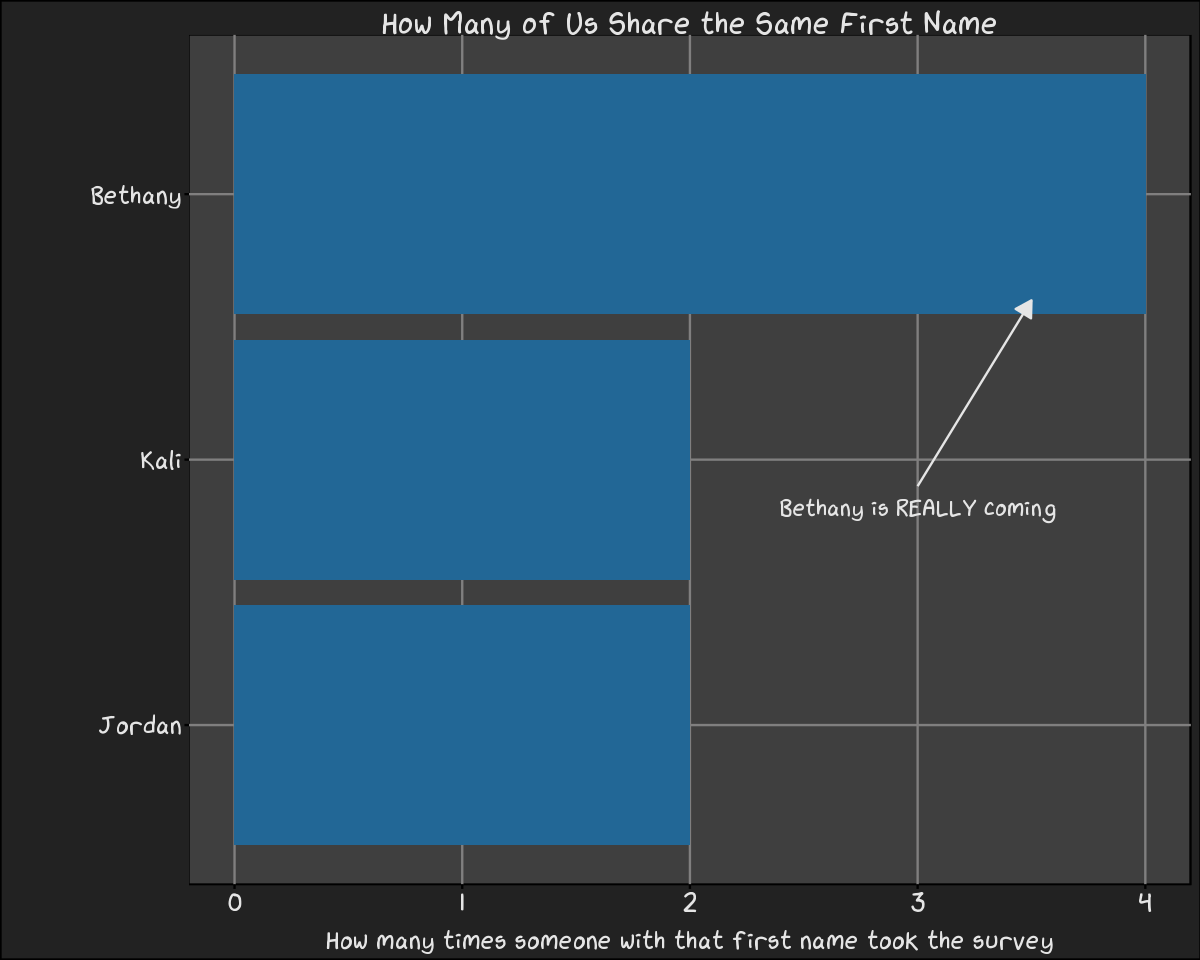

In [504]:
data |>
    group_by(first.name.raw) %>%
    mutate(order = n()) |>
    filter(order > 1) |>
    filter(!is.na(first.name.raw)) |>
ggplot(aes(y=reorder(first.name.raw, order))) +
    geom_bar(fill=color) +
    geom_arrow(x=3.5, y=2.6, dx=-.5, dy=-.7, text='Bethany is REALLY coming', text_dy = -.08) +
    labs(title = 'How Many of Us Share the Same First Name', y='', x='How many times someone with that first name took the survey')


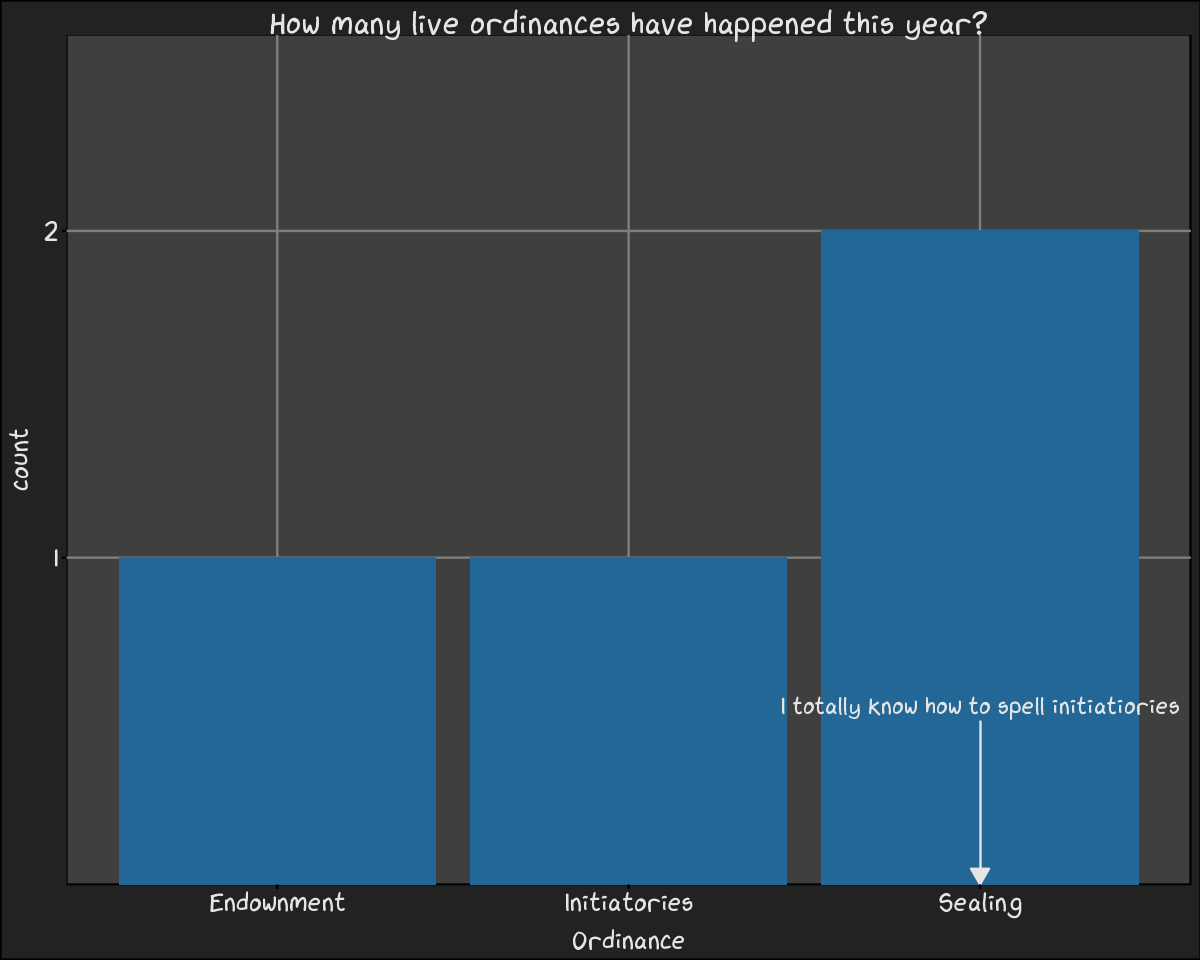

In [535]:
str_split(na.omit(serious_data$ordinances.self), ',') |>
    flatten() |>
    tibble() |>
    rename(Ordinance=1) |>
    mutate(Ordinance=str_trim(Ordinance)) |>
    count(Ordinance) |>
    rename(count=n) |>
    mutate(count = as.character(count), Ordinance=as.character(Ordinance)) |>
ggplot(aes(x=Ordinance, y=count)) +
    geom_col(fill=color) +
    geom_arrow(x=3, y=0, dx=0, dy=.5, "I totally know how to spell initiatiories", text_dy=.05) +
    # scale_y_continuous(breaks = 0:6) +
    labs(title = 'How many live ordinances have happened this year?')


`geom_smooth()` using formula = 'y ~ x'


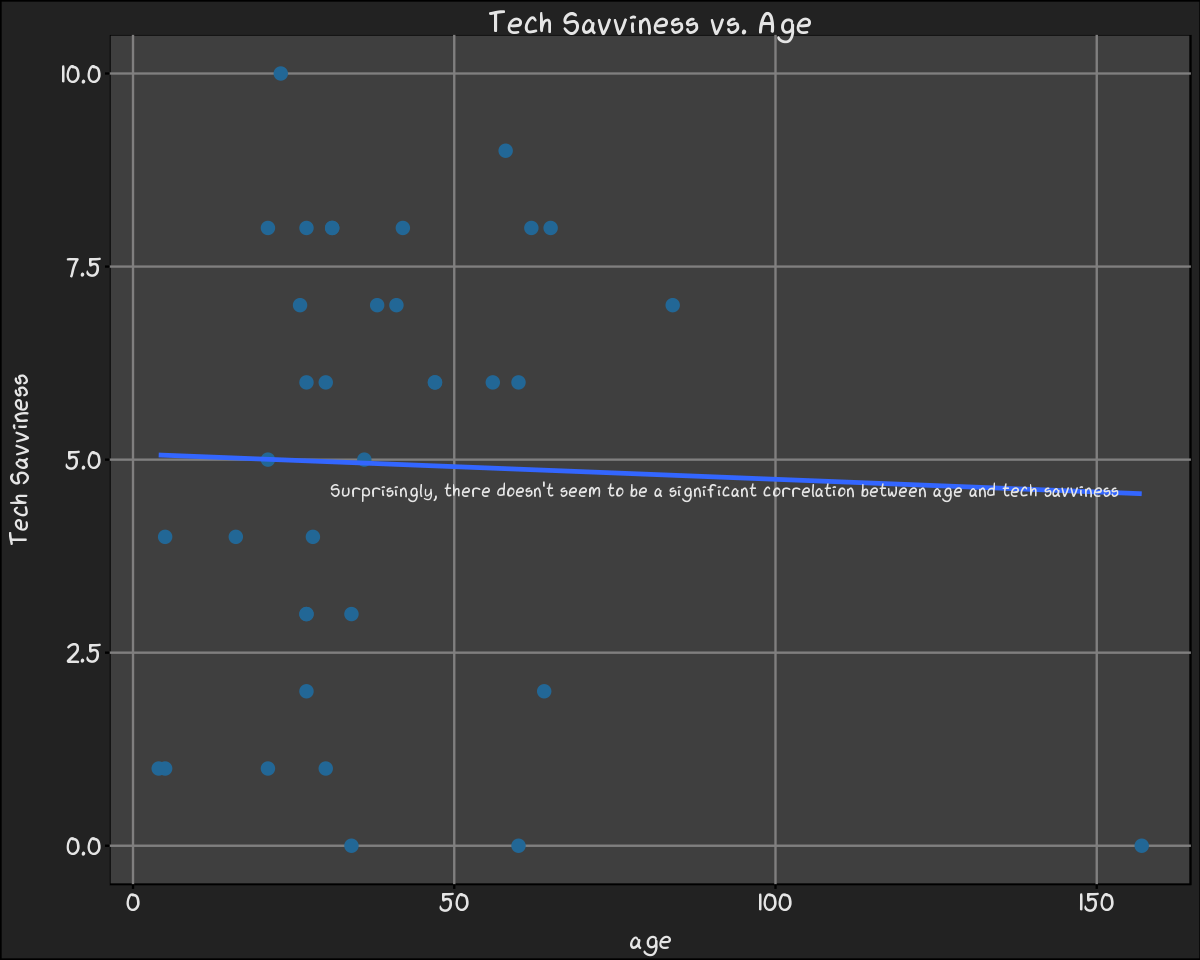

In [506]:
serious_data |>
    filter(age < 200) |>
    arrange(age) |>
ggplot(aes(x=age, y=tech.savviness)) +
    geom_point(color=color, size=3) +
    geom_smooth(method='lm', se=F, na.rm=T) +
    annotate('text', x=92, y=4.6, label='Surprisingly, there doesn\'t seem to be a significant correlation between age and tech savviness', size=5, family=theme_get()$text$family, color=theme_get()$text$colour) +
    labs(y="Tech Savviness", title='Tech Savviness vs. Age')

`summarise()` has grouped output by 'indexed'. You can override using the
`.groups` argument.


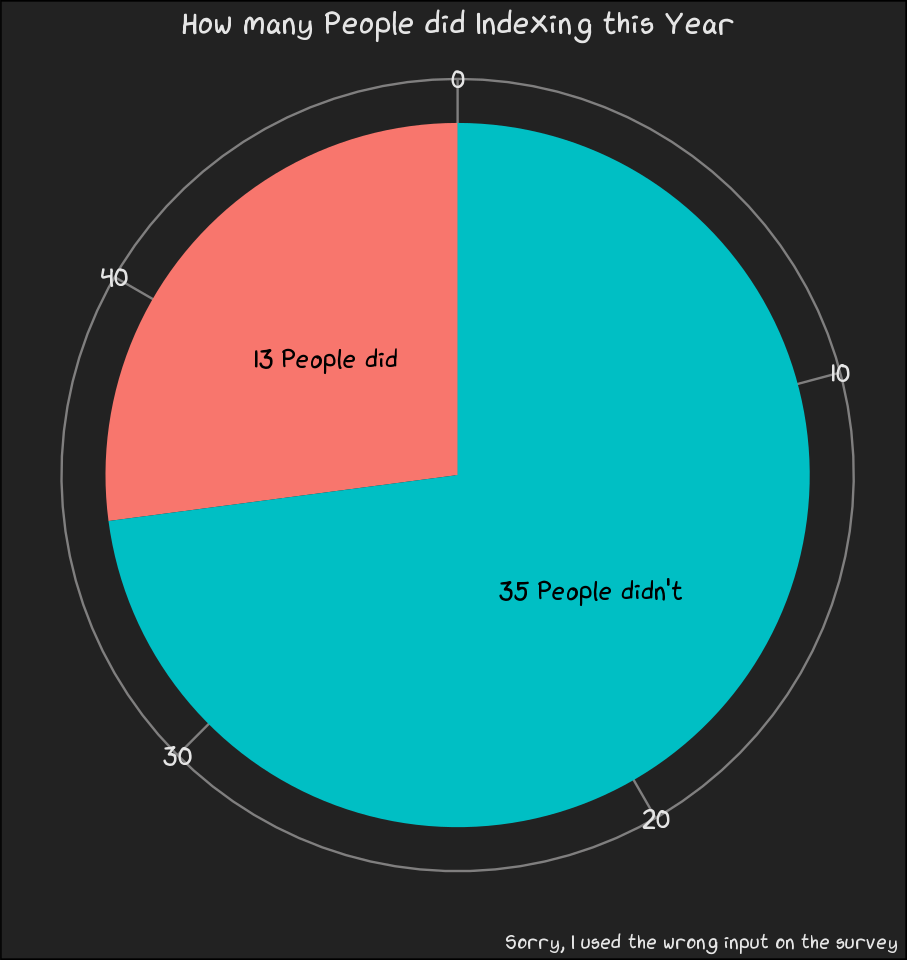

In [519]:
options(
    # No idea why it's adding bars unless I size it just right
    repr.plot.width=7.56,
    repr.plot.height=8
)
data |>
    filter(!is.na(names.indexed)) |>
    mutate(indexed = ifelse(names.indexed > 0, 'did', "didn't")) |>
    group_by(indexed, label=indexed) |>
    summarize(indexed = n()) |>
ggplot(aes(y=indexed, x='', fill=label, label=glue('{indexed} People {label}'))) +
    geom_col() +
    theme(
        panel.background = element_blank(),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        # axis.text.y = element_blank(),
        panel.grid=element_blank(),
        # axis.text = element_blank(),
        legend.position = 'none',
        plot.title = element_text(hjust=.5),
    ) +
    geom_text(position=position_stack(vjust=.5), family=theme_get()$text$family, size=7) +
    coord_polar(theta='y') +
    labs(x='', y='', title='How many People did Indexing this Year', caption="Sorry, I used the wrong input on the survey")


`summarise()` has grouped output by 'oldest'. You can override using the
`.groups` argument.


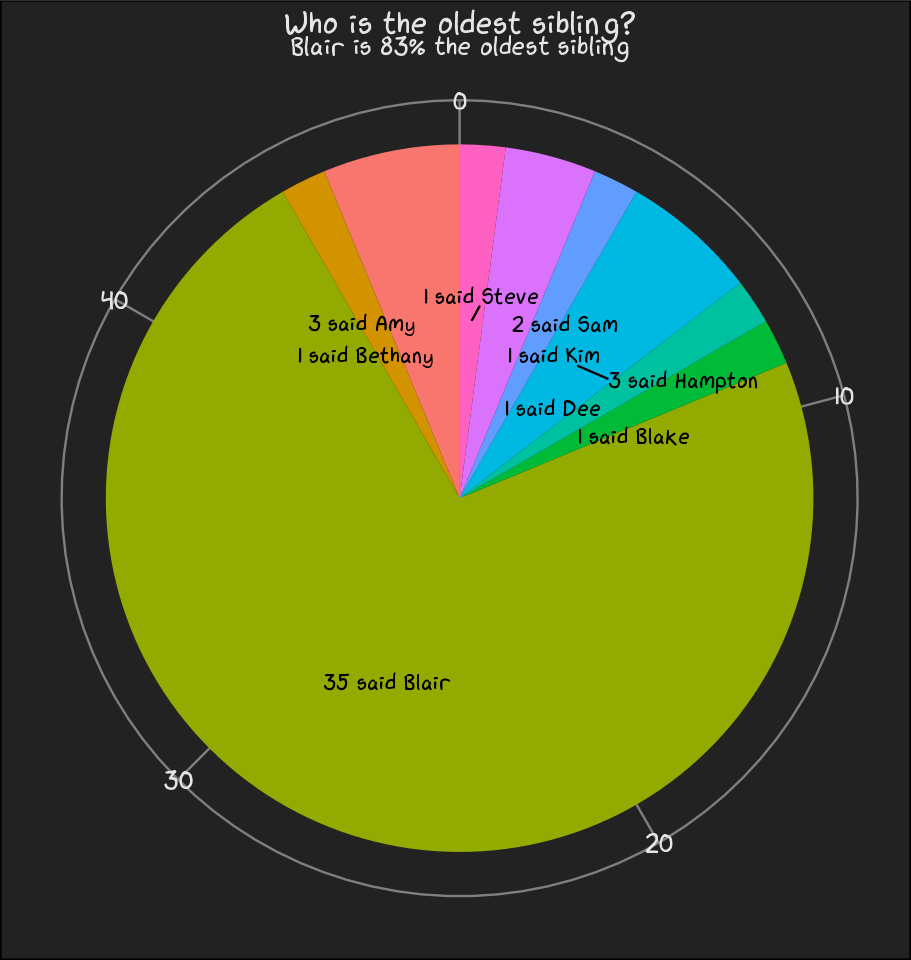

In [524]:
options(
    # No idea why it's adding bars unless I size it just right
    repr.plot.width=7.59,
    repr.plot.height=8
)
data |>
    filter(!is.na(oldest)) |>
    group_by(oldest, label=oldest) |>
    summarize(oldest = n()) |>
ggplot(aes(y=oldest, x='', fill=label, label=glue('{oldest} said {label}'))) +
    geom_col() +
    theme(
        panel.background = element_blank(),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        # axis.text.y = element_blank(),
        panel.grid=element_blank(),
        # axis.text = element_blank(),
        legend.position = 'none',
        # plot.title = element_text(hjust=.5, family=theme_get()$text$family, size=15),
        # plot.subtitle = element_text(hjust=.5, family=theme_get()$text$family, size=15),
    ) +
    geom_text_repel(position=position_stack(vjust=.5), family=theme_get()$text$family, size=6) +
    coord_polar(theta='y') +
    labs(x='', y='', subtitle='Blair is 83% the oldest sibling', title='Who is the oldest sibling?')

## Interesting Lists

In [509]:
lists = data |> select('name', 'worst.advice', 'best.advice', 'secret', 'fav.game', 'most.told.story', 'suggested.reunion.location', 'suggested.activity', 'fav.part')

In [510]:
options(
    repr.matrix.max.rows=200,
    repr.matrix.max.cols=200
)
lists

name,worst.advice,best.advice,secret,fav.game,most.told.story,suggested.reunion.location,suggested.activity,fav.part
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Amy,Spank your kid,When angry with spouse go to sleep,I love car chases in movies,Water fight,My birth story,Fiji,Fishing,Programs & laughing with everyone
Danae Weber,Sleep when the baby sleeps... Do the dishes when the baby does the dishes. Do the laundry when the baby does the laundry.,Don't be an idiot. Changed my life.,I'm a pretty good event planner,Spin the bottle,"Grandma being tired of her boys fighting, so she tossed them in the yard with boxing gloves and told them to duke it out",Hawaii,Strong gene games,Staying up late
Jaren,I recommend buying a fleet of transports right now,Praise in public,I love writing poetry,Strip crib,Grandpa Dee ALMOST catching a jack rabbit with his bare hands,Holland,Water skiing,Staying up late
Blair,NA,Cause that is what we do,Ham radio operator,NA,NA,NA,Pickleball,Renewing friendships
McKelle,Just take care of yourself,Thuesons love and serve one another!!,I’m missing the reunion because I’m in Peru!,NA,NA,Camping somewhere new,NA,Games
Katelan Shakespear,It’s ok to go to bed mad at each other,Don’t let your kids sleep in your bed.,I hate olives,"Relays, volleyball, pickleball",When she was having babies!,"Anywhere, as long as we have it!",Big group games,Talking around the camp fire
Kelli Thueson,Don’t go to the doctor’s office if you only have one problem. Wait until you have four or five; that’s how you get the most bang for your buck.',My feelings don’t have an IQ,I can roll my tongue into the shape of a cover,Pickleball,Baby Blair throwing up root beer float (i think) on her busty grandma in the car and it going down said grandmother’s blouse.,Hawaii,Steak on rocks,Games at night
Jenelle Thueson,NA,Keep smiling,How many missions have I been on so far?,NA,Teton Dam flood,Place doesn’t matter to me,NA,Being together sharing testimonies
Lyndee,NA,NA,How many fake teeth I have,Signs,Grandpa catching the rabbit,NA,Eat scones,Rafting and sunshine
